In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from babel.numbers import get_currency_symbol
import humanize

# Data For Good - Tax Observatory Dataviz

Visualizations for the EU Tax Observatory based on the [EU Tax Obs - Dataviz - Viz](https://docs.google.com/document/d/1q_7x8NrEWNsak9LSE3TxIiSphhVcqWqn6YeG1kQNQTk/edit#heading=h.97g77izer615) Google Docs.

## Table of contents
* [Initialization](#initialization)
* [#12 - available reports by company](#12---available-reports-by-company)
* [#13 - company key financials kpis](#13---company-key-financials-kpis)
* [#14 - company top jurisdictions for revenue](#14---company-top-jurisdictions-for-revenue)

## Initialization

In [2]:
# Import dataset in a DataFrame
df = pd.read_csv('data_final_dataviz.csv', sep=',')

In the website it will be possible to select a specific company. To work on the viz creation, we simulate the selection by picking a random company but also a random year.

In [3]:
# Select a random company and a random year
def pick_random_company_and_year() -> tuple:
    company = np.random.choice(df['mnc'].unique())
    print(f'Selected company : {company}.')

    year = np.random.choice(df.loc[df['mnc'] == company, 'year'].unique())
    print(f'Selected year : {year}.')

    return company, year

In [4]:
company, year = pick_random_company_and_year()
# company, year = 'SHELL', 2020

Selected company : ADYEN.
Selected year : 2021.


## #12 - available reports by company

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|tbd (goal is on company page, to show reports tracked, so could be just a table showing year available for a company)|-||`company explo` need a filter by company||

In [5]:
def compute_company_available_reports(
        df: pd.DataFrame=df, company: str=company) -> dict:
    
    available_years = df.loc[df['mnc'] == company, 'year'].unique()
    n_reports = len(available_years)

    # Convert type of items from 'int' to 'str' in available years list
    years_string_list = [str(year) for year in available_years]
    
    if len(years_string_list) == 1:
        years_string = years_string_list[0]
    elif len(years_string_list) > 1:
        years_string = ', '.join(years_string_list[:-1])
        years_string += ' and ' + years_string_list[-1]

    data = {
        'Company': company,
        'Reports': n_reports,
        'Fiscal year(s) available': years_string
    }

    return data


data =compute_company_available_reports()
pd.DataFrame.from_dict(data=data, orient='index').style.hide(axis='columns')

Company,ADYEN
Reports,3
Fiscal year(s) available,"2020, 2021 and 2022"


## #13 - company key financials kpis

**kpis** : hq country, total revenue, total unrelated party revenues, total related party revenues, pre-tax profits, taxes paid, employees.

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|raw figure for each, or table with indicator name in col A, value in col B|hq country : -<br><br>metrics : sum (metric) by year by mnc|**giulia : keep all values, even negative values**|`company explo` need a filter by company||

In [6]:
def compute_company_key_financials_kpis(
        df: pd.DataFrame=df, company: str=company, year: int=None) -> dict:
    
    # List financial kpis
    kpis_list = ['total_revenues', 'unrelated_revenues', 'related_revenues', 
                 'profit_before_tax', 'tax_paid', 'employees']
    
    years = df.loc[df['mnc'] == company, 'year'].unique()
    currency = df['currency'].unique()[0]
    currency_symbol = get_currency_symbol(currency, locale='en_US')

    if not year or year not in years:
        df = (df.loc[df['mnc'] == company]
            .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
            .sum()
        )
    else:
        df = (df.loc[(df['mnc'] == company) & (df['year'] == year)]
              .groupby(['year', 'upe_name'], as_index=False)[kpis_list]
              .sum())

    df = df.set_index('year')

    for column in df.columns:
        if column not in ['employees', 'upe_name']:
            df[column] = df[column].apply(
                lambda x: humanize.intword(x) if isinstance(x, (int, float)) else x)
            df[column] = currency_symbol + ' ' + df[column]
        elif column == 'employees':
            df[column] = df[column].astype(int)

    df = df.rename(columns={'upe_name': 'headquarter'})
    df.columns = df.columns.str.replace('_', ' ').str.capitalize()

    data = df.to_dict(orient='index')

    return data

In [7]:
data = compute_company_key_financials_kpis()
pd.DataFrame.from_dict(data)

,2020,2021,2022
Headquarter,Netherlands,Netherlands,Netherlands
Total revenues,€ 0,€ 0,€ 0
Unrelated revenues,€ 0,€ 0,€ 0
Related revenues,€ 0,€ 0,€ 0
Profit before tax,€ 323.2 million,€ 580.8 million,€ 719.9 million
Tax paid,€ 0,€ 127.4 million,€ 149.6 million
Employees,1747,2180,3332


## #14 - company top jurisdictions for revenue

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart showing % total revenue for top 9 jurisdictions + rest as “OTHERS”|sum(revenue) by company x hq country x year, display top 9 and group remaining countries||`company explo` need a filter by company||

In [8]:
def compute_top_jurisdictions_revenue(
        df: pd.DataFrame=df, company: str=company, year:int=year) -> dict:
    
    df = df.loc[(df['mnc'] == company) & (df['year'] == year), ['jur_name', 'total_revenues']]
    df = df.fillna(0)
    df = df.sort_values(by='total_revenues', ascending=False)

    top = df[:9].copy()

    others = df[9:]['total_revenues'].sum()
    top.loc[9] = ['Others', others]

    top['total_revenues_%'] = top['total_revenues'] / top['total_revenues'].sum() * 100

    top = top.sort_values(by='total_revenues_%').reset_index(drop=True)

    data = top.to_dict()
    
    return data

In [9]:
pd.DataFrame(compute_top_jurisdictions_revenue())

,jur_name,total_revenues,total_revenues_%
0,Netherlands,0.0,NaN
1,United Kingdom,0.0,NaN
2,Malaysia,0.0,NaN
3,New Zealand,0.0,NaN
4,India,0.0,NaN
5,Hong Kong,0.0,NaN
6,Japan,0.0,NaN
7,China,0.0,NaN
8,Australia,0.0,NaN
9,Others,0.0,NaN


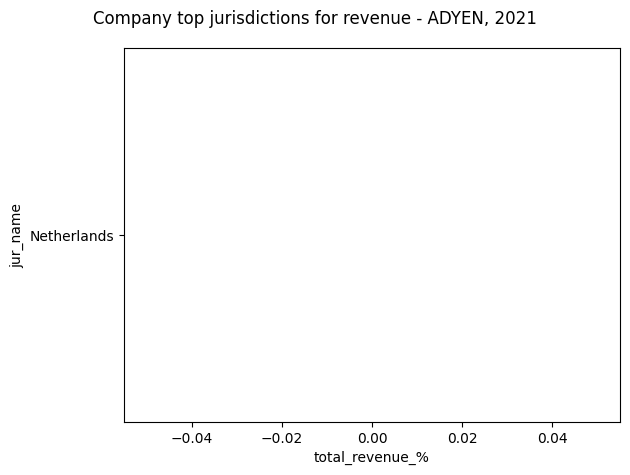

In [10]:
def plot_jurisdictions_top_revenue():

    top = pd.DataFrame(compute_top_jurisdictions_revenue())

    fig, ax = plt.subplots()
    bar = ax.barh(y=top['jur_name'], width=top['total_revenues_%'])

    ax.bar_label(bar, fmt='{:.1f} %', padding=1)

    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('total_revenue_%')
    ax.set_ylabel('jur_name')

    fig.suptitle(f'Company top jurisdictions for revenue - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_jurisdictions_top_revenue()

## #15 - company’s % pre-tax profit and % employees by jurisdiction

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart with one bar for % pre tax profit, the other for % employees, in different colors rank by % pre-tax profit descending|for a company : filter (profit >0) profits by JUR / total profit vs employees by JUR / total employees|**giulia : keep only positive values**|`company explo` need a filter by company||

In [11]:
def compute_pretax_profit_and_employees_rank(
        df: pd.DataFrame=df, company: str=company, year: int=year) -> dict:
    
    df = df.loc[
        (df['mnc'] == company) & (df['year'] == year) & (df['profit_before_tax'] > 0), 
        ['jur_name', 'profit_before_tax', 'employees']
    ]

    df = df.fillna(0)
    df = df.sort_values(by='profit_before_tax').reset_index(drop=True)

    df['profit_before_tax_%'] = df['profit_before_tax'] / df['profit_before_tax'].sum() * 100
    df['employees_%'] = df['employees'] / df['employees'].sum() * 100

    data = df.to_dict()

    return data

In [12]:
pd.DataFrame(compute_pretax_profit_and_employees_rank())

,jur_name,profit_before_tax,employees,profit_before_tax_%,employees_%
0,New Zealand,90000.0,0.0,0.015494,0.000000
1,Malaysia,149000.0,1.0,0.025651,0.045872
2,United Arab Emirates,231000.0,10.0,0.039768,0.458716
3,Mexico,253000.0,14.0,0.043555,0.642202
4,Japan,270000.0,19.0,0.046482,0.871560
5,Belgium,353000.0,12.0,0.060771,0.550459
6,Poland,402000.0,10.0,0.069207,0.458716
7,Canada,426000.0,10.0,0.073338,0.458716
8,Italy,494000.0,17.0,0.085045,0.779817
9,Hong Kong,649000.0,6.0,0.111729,0.275229


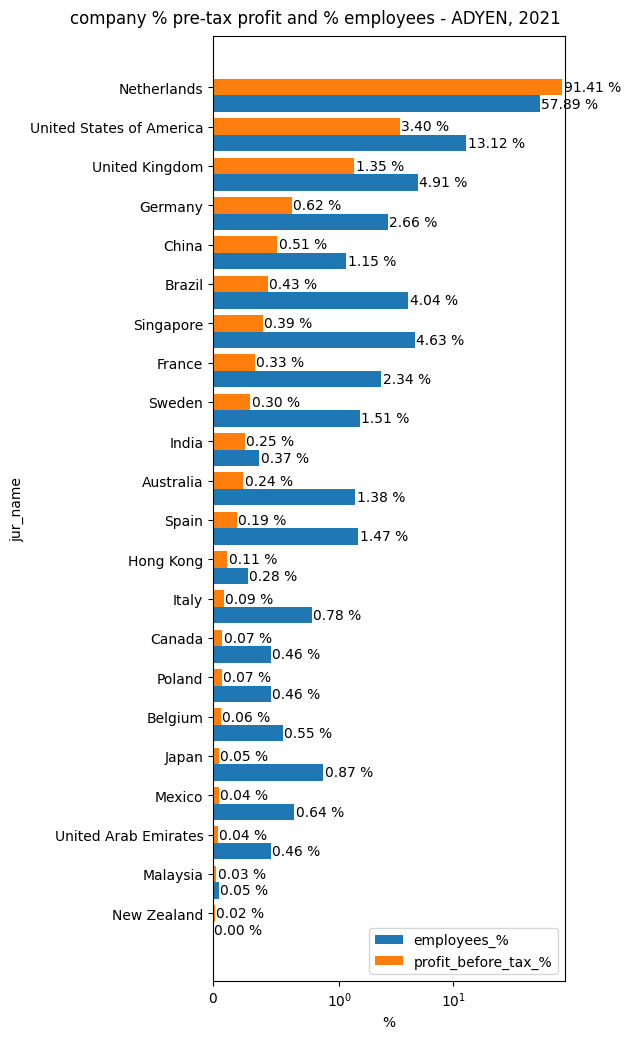

In [28]:
def plot_pretax_profit_and_employees_rank():

    rank = pd.DataFrame(compute_pretax_profit_and_employees_rank())

    jurisdictions = rank['jur_name'].values
    bar_width = 0.42
    bar_offsets = [-bar_width, 0, bar_width]

    fig, ax = plt.subplots(figsize=(6.4, 0.48 * len(jurisdictions)))

    for i, (column, values) in enumerate(rank[['employees_%', 'profit_before_tax_%']].items()):
        bar_positions = []
        for j in range(len(jurisdictions)):
            bar_positions.append(j + bar_offsets[i])
        bars = ax.barh(bar_positions, values, height=bar_width, label=column)
        ax.bar_label(bars, fmt='{:.2f} %', padding=1)

    ax.set_xlabel('%')
    ax.set_yticks(range(len(jurisdictions)))
    ax.set_yticklabels(jurisdictions)
    ax.set_ylabel('jur_name')
    ax.set_xscale('symlog', linthresh=1)
    ax.legend(loc='lower right')
       
    fig.suptitle(f'company % pre-tax profit and % employees - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_pretax_profit_and_employees_rank()